In [2]:
from scipy.integrate import solve_ivp
import numpy as np

In [3]:
def covid_model_ga(t, y, pars, agepars):
    
    dydt = np.zeros(len(y))
    
    # Total asymptomatic
    Ia = sum(y[agepars["Ia_ids"]])
    
    # Total symptomatic
    Is = sum(y[agepars["Is_ids"]])
    
    # Total recovered
    R = sum(y[agepars["R_ids"]])
    
    # Total susceptible
    S = sum(y[agepars["S_ids"]])
    
    # Total exposed
    E = sum(y[agepars["E_ids"]])

    # Dynamics -  Base Model
    
    # Susceptible
    dydt[agepars["S_ids"]] = -pars["beta_a"] * y[agepars["S_ids"]] * Ia - \
                            pars["beta_s"] * y[agepars["S_ids"]] * Is
    
    # Exposed
    dydt[agepars["E_ids"]] = pars["beta_a"] * y[agepars["S_ids"]] * Ia + \
                            pars["beta_s"] * y[agepars["S_ids"]] * Is - pars["gamma_e"] * y[agepars["E_ids"]]
    
    # Infectious asymptomatically
    dydt[agepars["Ia_ids"]] = np.transpose(pars["p"]) * pars["gamma_e"] * y[agepars["E_ids"]] - \
                            pars["gamma_a"] * y[agepars["Ia_ids"]]
    
    # Infectious symptomatically
    dydt[agepars["Is_ids"]] = np.transpose(np.ones(len(pars["p"])) - pars["p"]) * pars["gamma_e"] * \
                            y[agepars["E_ids"]] - pars["gamma_s"] * y[agepars["Is_ids"]]
    
    # Symptomatic cases requiring hospital care (subacute)
    dydt[agepars["Ihsub_ids"]]= np.transpose(agepars["hosp_frac"]) * (1 - np.transpose(agepars["hosp_crit"])) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] - pars["gamma_h"] * y[agepars["Ihsub_ids"]]
    
    # Symptomatic cases requiring ICU intervention (acute/critical)
    dydt[agepars["Ihcri_ids"]]= np.transpose(agepars["hosp_frac"]) * np.transpose(agepars["hosp_crit"]) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] - pars["gamma_h"] * y[agepars["Ihcri_ids"]]
    
    # Recovered
    dydt[agepars["R_ids"]]= pars["gamma_a"] * y[agepars["Ia_ids"]] + \
                            pars["gamma_s"] * y[agepars["Is_ids"]] * (1 - np.transpose(agepars["hosp_frac"])) + \
                            pars["gamma_h"] * y[agepars["Ihsub_ids"]] + \
                            pars["gamma_h"] * y[agepars["Ihcri_ids"]] * (1 - np.transpose(agepars["crit_die"]))
    
    # Deaths
    dydt[agepars["D_ids"]] = pars["gamma_h"] * y[agepars["Ihcri_ids"]] * np.transpose(agepars["crit_die"])
    
    # HFR. Hospitalization fatality risk. Infectious and hospitalized
    dydt[agepars["Hcum_ids"]]= np.transpose(agepars["hosp_frac"]) * (1 - np.transpose(agepars["hosp_crit"])) * \
                            pars["gamma_s"] * y[agepars["Is_ids"]] + np.transpose(agepars["hosp_frac"]) * \
                            np.transpose(agepars["hosp_crit"]) * pars["gamma_s"] * y[agepars["Is_ids"]]
    # Is it the same as?
    #dydt[agepars["Hcum_ids"]]= np.transpose(agepars["hosp_frac"]) * pars["gamma_s"] * y[agepars["Is_ids"]] 

    return dydt

## Reset

### Population

In [4]:
agepars = {}
# Age groups
agepars["meanage"] = np.arange(5, 96, 10)
agepars["highage"] = np.arange(9, 100, 10)
agepars["lowage"] = np.arange(0, 91, 10)

In [5]:
# From 2018 Census
population = {}
population["N"] = 10666108;
population["agefrac"] = np.array([0.126, 0.137, 0.139, 0.132, 0.130, 0.129, 0.104, 0.061, 0.036, 0.007]);
# Must sum to 1
population["agefrac"] = population["agefrac"]/sum(population["agefrac"])
population["meanage"] = sum(agepars["meanage"] * population["agefrac"])

## Parameters


In [6]:
pars = {}

#From exposed to infectious. 1/gamma_e = mean exposed period
pars["gamma_e"] = 1/4

#From asymptomatic to recovered. Resolution rate for asymptomatic. 1/gamma_a = mean asymptomatic period
pars["gamma_a"] = 1/6

#From symptomatic to recovered. Resolution rate for symptomatic. 1/gamma_s = mean symptomatic period
pars["gamma_s"] = 1/6

#From subacute to recovered. 1/gamma_h = mean hospital period
pars["gamma_h"] = 1/10

#From susceptible to asymptomatic exposed. beta_a = transmission for asymptomatic
pars["beta_a"] = 4/10

#From susceptible to symptomatic exposed. beta_s = transmission for symptomatic
pars["beta_s"] = 8/10

#Fraction of asymptomatic per age group
pars["p"] = np.array([0.95, 0.95, 0.90, 0.8, 0.7, 0.6, 0.4, 0.2, 0.2, 0.2])
pars["overall_p"] = sum(pars["p"] * population["agefrac"])
pars["Itrigger"] = 45000/population["N"]; 

In [7]:
agepars["num_ages"]  = len(agepars["meanage"]);
N = agepars["num_ages"]

# Fraction of hospitalized individuals per age group 
agepars["hosp_frac"] = np.array([0.1, 0.3, 1.2, 3.2, 4.9, 10.2, 16.6, 24.3, 27.3, 27.3])/100

# Fraction of ICU needed given hospitalization
agepars["hosp_crit"] = np.array([5, 5, 5, 5, 6.3, 12.2, 27.4, 43.2, 70.9, 70.9])/100

# Fraction of deaths given ICU
agepars["crit_die"] = 0.5 * np.ones(N);

# Set up indexes for each group 
agepars["S_ids"] = np.arange(0, N)
agepars["E_ids"] = np.arange(N, 2*N)
agepars["Ia_ids"] = np.arange(2*N, 3*N)
agepars["Is_ids"] = np.arange(3*N, 4*N)
agepars["Ihsub_ids"] = np.arange(4*N, 5*N)
agepars["Ihcri_ids"] = np.arange(5*N, 6*N)
agepars["R_ids"] = np.arange(6*N, 7*N)
agepars["D_ids"] = np.arange(7*N, 8*N)
agepars["Hcum_ids"] = np.arange(8*N, 9*N)

 ## Epi parameters

In [8]:
# Transmission for asymptomatic / Resolution rate for asymptomatic
pars["Ra"] = pars["beta_a"]/pars["gamma_a"]

# Transmission for symptomatic / Resolution rate for symptomatic
pars["Rs"] = pars["beta_s"]/pars["gamma_s"]

# Basic reproduction number
# If no age stratification: 
# pars["R0"] = pars["p"] * pars["Ra"] + (1 - pars["p"]) * pars["Rs"]

# With age stratification:
pars["R0"] = sum(pars["p"] * population["agefrac"] * pars["Ra"] + 
                 (1 - pars["p"] ) * population["agefrac"] * pars["Rs"])

## Init the population - baseline


In [9]:
tmpzeros = np.zeros(N)

outbreak = {}
outbreak["y0"] = np.concatenate((population["agefrac"], tmpzeros, tmpzeros,
                                 tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros, tmpzeros), axis = None)

# Initiate an outbreak
# Remove one person from the Susceptible population, third agegroup
# Move that person to the Exposed population, third age group
outbreak["y0"] = population["N"] * outbreak["y0"]
outbreak["y0"][2] = outbreak["y0"][2]-1
outbreak["y0"][12] = 1
outbreak["y0"] = outbreak["y0"]/population["N"]
outbreak["pTime"] = 365
outbreak["pNear"] = 30
outbreak["pshift"] =  0

## Sims - Get to Crossing

In [10]:
# From susceptible to asymptomatic exposed. beta_a = transmission for asymptomatic
pars["beta_a"] = 4/10
# From susceptible to asymptomatic exposed. beta_a = transmission for asymptomatic
pars["beta_s"] = 8/10
# From parameter fitting
pars_base = pars
t0_opt = 67 + 7
te = t0_opt

In [11]:
# Trigger approach
# opts=odeset('reltol',1e-8,'maxstep',0.1,'events',@intervene_trigger);
# [tpre,ypre,te,ye,ie]=ode45(@covid_model_ga,[0:1:outbreak.pTime], outbreak.y0,opts,pars,agepars);

# Parameter fit approach
sol_pre = solve_ivp(covid_model_ga, (0, t0_opt + 1), outbreak["y0"], t_eval = np.arange(0, t0_opt + 1 , 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1)
# Baseline case
sol_pos = solve_ivp(covid_model_ga, (0, outbreak["pNear"] + 1) , np.transpose(sol_pre.y)[-1], \
                    t_eval =  np.arange(0, outbreak["pNear"] + 1, 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1)

/home/dgarcia/Workspace/covid-19-ga-summer-2020/covid_env/lib/python3.5/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `reltol`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


In [12]:
t_base = np.concatenate((sol_pre.t[0:-1]-te, sol_pos.t))
y_base = np.vstack((np.transpose(sol_pre.y)[0:-1], np.transpose(sol_pos.y)))

### Stats

In [13]:
stats_base = {}
stats_base["R"] = y_base[:,agepars["R_ids"]]
stats_base["D"] = y_base[:,agepars["D_ids"]]
stats_base["Htot"] = y_base[:,agepars["Ihsub_ids"]] + y_base[:,agepars["Ihcri_ids"]]
stats_base["Hacu"] = y_base[:,agepars["Ihcri_ids"]]
stats_base["Dday_age"] = stats_base["D"][1:,:] - stats_base["D"][0:-1,:]
stats_base["Dday"] = sum(np.transpose(stats_base["Dday_age"]))
stats_base["Dcum"] = sum(np.transpose(stats_base["D"]))
stats_base["Hacu_day"] = sum(np.transpose(stats_base["Hacu"]))
stats_base["fracI"] = 1 - sum(np.transpose(y_base[:,agepars["S_ids"]]))
stats_base["Is"] = sum(np.transpose(y_base[:,agepars["Is_ids"]]))
stats_base["Iday"] = stats_base["Is"][1:] - stats_base["Is"][0:-1]
stats_base["Isevere"] = sum(np.transpose(y_base[:,3*N:6*N + 1]))

In [14]:
tmpi = np.where(t_base <= 0)
Htot = sum(np.transpose(stats_base["Htot"][tmpi]))
Dcum = stats_base["Dcum"][tmpi]

## % Sims - 25%

In [15]:
# Transmission for asymptomatic
pars["beta_a"] = 4*0.75/10
# Transmission for symptomatic
pars["beta_s"] = 8*0.75/10 
# From parameter fitting
pars_low = pars
sol_pos = solve_ivp(covid_model_ga, (0, outbreak["pNear"] + 1) , np.transpose(sol_pre.y)[-1], \
                    t_eval =  np.arange(0, outbreak["pNear"] + 1, 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1)

t_low = np.concatenate((sol_pre.t[0:-1]-te, sol_pos.t))
y_low = np.vstack((np.transpose(sol_pre.y)[0:-1], np.transpose(sol_pos.y)))

### Stats

In [16]:
stats_low = {}
stats_low["R"] = y_low[:,agepars["R_ids"]]
stats_low["D"] = y_low[:,agepars["D_ids"]]
stats_low["Htot"] = y_low[:,agepars["Ihsub_ids"]] + y_low[:,agepars["Ihcri_ids"]]
stats_low["Hacu"] = y_low[:,agepars["Ihcri_ids"]]
stats_low["Dday_age"] = stats_low["D"][1:,:] - stats_low["D"][0:-1,:]
stats_low["Dday"] = sum(np.transpose(stats_low["Dday_age"]))
stats_low["Dcum"] = sum(np.transpose(stats_low["D"]))
stats_low["Hacu_day"] = sum(np.transpose(stats_low["Hacu"]))
stats_low["fracI"] = 1 - sum(np.transpose(y_low[:,agepars["S_ids"]]))
stats_low["Is"] = sum(np.transpose(y_low[:,agepars["Is_ids"]]))
stats_low["Iday"] = stats_low["Is"][1:] - stats_low["Is"][0:-1]

## % Sims - 50%

In [17]:
# Transmission for asymptomatic
pars["beta_a"] = 4*0.5/10
# Transmission for symptomatic
pars["beta_s"] = 8*0.5/10 
pars_med = pars
sol_pos = solve_ivp(covid_model_ga, (0, outbreak["pNear"] + 1) , np.transpose(sol_pre.y)[-1], \
                    t_eval =  np.arange(0, outbreak["pNear"] + 1, 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1)

t_med = np.concatenate((sol_pre.t[0:-1]-te, sol_pos.t))
y_med = np.vstack((np.transpose(sol_pre.y)[0:-1], np.transpose(sol_pos.y)))

### Stats

In [18]:
stats_med = {}
stats_med["R"] = y_med[:,agepars["R_ids"]]
stats_med["D"] = y_med[:,agepars["D_ids"]]
stats_med["Htot"] = y_med[:,agepars["Ihsub_ids"]] + y_med[:,agepars["Ihcri_ids"]]
stats_med["Hacu"] = y_med[:,agepars["Ihcri_ids"]]
stats_med["Dday_age"] = stats_med["D"][1:,:] - stats_med["D"][0:-1,:]
stats_med["Dday"] = sum(np.transpose(stats_med["Dday_age"]))
stats_med["Dcum"] = sum(np.transpose(stats_med["D"]))
stats_med["Hacu_day"] = sum(np.transpose(stats_med["Hacu"]))
stats_med["fracI"] = 1 - sum(np.transpose(y_med[:,agepars["S_ids"]]))
stats_med["Is"] = sum(np.transpose(y_med[:,agepars["Is_ids"]]))
stats_med["Iday"] = stats_med["Is"][1:] - stats_med["Is"][0:-1]

## % Sims - Low, Severe Control

In [20]:
# Transmission for asymptomatic
pars["beta_a"] = 4*0.25/10
# Transmission for symptomatic
pars["beta_s"] = 8*0.25/10 
pars_high = pars
sol_pos = solve_ivp(covid_model_ga, (0, outbreak["pNear"] + 1) , np.transpose(sol_pre.y)[-1], \
                    t_eval =  np.arange(0, outbreak["pNear"] + 1, 1), \
                    args = (pars,agepars), reltol = 1e-8, max_step = 0.1)

t_high = np.concatenate((sol_pre.t[0:-1]-te, sol_pos.t))
y_high = np.vstack((np.transpose(sol_pre.y)[0:-1], np.transpose(sol_pos.y)))

### Stats

In [21]:
stats_high = {}
stats_high["R"] = y_high[:,agepars["R_ids"]]
stats_high["D"] = y_high[:,agepars["D_ids"]]
stats_high["Htot"] = y_high[:,agepars["Ihsub_ids"]] + y_high[:,agepars["Ihcri_ids"]]
stats_high["Hacu"] = y_high[:,agepars["Ihcri_ids"]]
stats_high["Dday_age"] = stats_high["D"][1:,:] - stats_high["D"][0:-1,:]
stats_high["Dday"] = sum(np.transpose(stats_high["Dday_age"]))
stats_high["Dcum"] = sum(np.transpose(stats_high["D"]))
stats_high["Hacu_day"] = sum(np.transpose(stats_high["Hacu"]))
stats_high["fracI"] = 1 - sum(np.transpose(y_high[:,agepars["S_ids"]]))
stats_high["Is"] = sum(np.transpose(y_high[:,agepars["Is_ids"]]))
stats_high["Iday"] = stats_high["Is"][1:] - stats_high["Is"][0:-1]

# Plots

In [107]:
import matplotlib.pyplot as plt
import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import StrMethodFormatter

In [57]:
tmpi = np.where(t_base >= -10)

## Cummulative deaths

In [65]:
dc_base = stats_base["Dcum"][tmpi] * population["N"]
dc_low = stats_low["Dcum"][tmpi] * population["N"]
dc_med = stats_med["Dcum"][tmpi] * population["N"]
dc_high = stats_high["Dcum"][tmpi] * population["N"]

day_base = datetime.date.today()
dates = [day_base + datetime.timedelta(days=int(x)) for x in t_base[tmpi]]       
dates.sort()                                                             

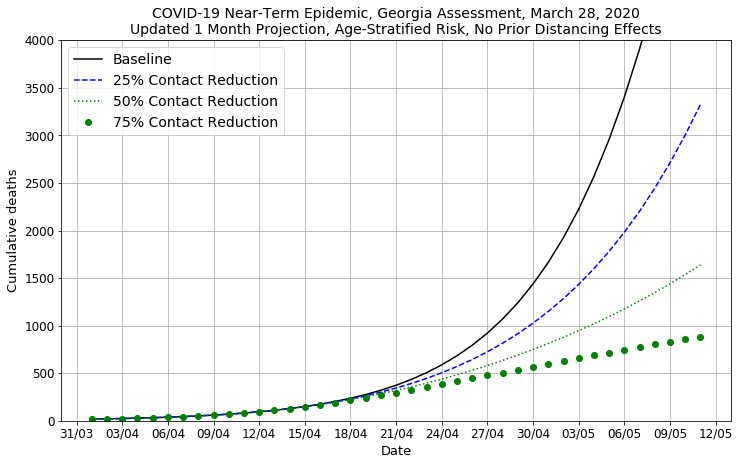

In [99]:
date_form = DateFormatter("%d/%m")

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, dc_base, 'k', label = "Baseline")
ax.plot(dates, dc_low, 'b--', label = "25% Contact Reduction")
ax.plot(dates, dc_med, 'g:', label = "50% Contact Reduction")
ax.plot(dates, dc_high, 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'Cumulative deaths', ylim= (0, 4000))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()

## ICU beds needed

In [90]:
hc_base = stats_base["Hacu_day"][tmpi] * population["N"]
hc_low = stats_low["Hacu_day"][tmpi] * population["N"]
hc_med = stats_med["Hacu_day"][tmpi] * population["N"]
hc_high = stats_high["Hacu_day"][tmpi] * population["N"]

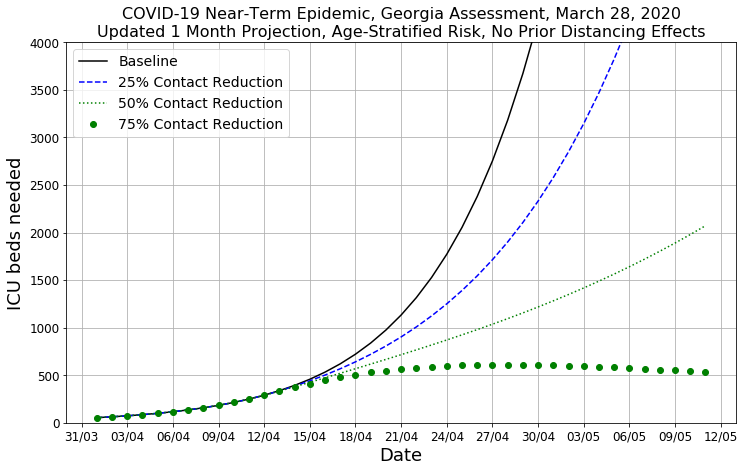

In [102]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, hc_base, 'k', label = "Baseline")
ax.plot(dates, hc_low, 'b--', label = "25% Contact Reduction")
ax.plot(dates, hc_med, 'g:', label = "50% Contact Reduction")
ax.plot(dates, hc_high, 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'ICU beds needed', ylim = (0, 4000))
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()

## Cummulative symptomatic cases

In [103]:
sc_base = stats_base["fracI"][tmpi] * population["N"]
sc_low = stats_low["fracI"][tmpi] * population["N"]
sc_med = stats_med["fracI"][tmpi] * population["N"]
sc_high = stats_high["fracI"][tmpi] * population["N"]

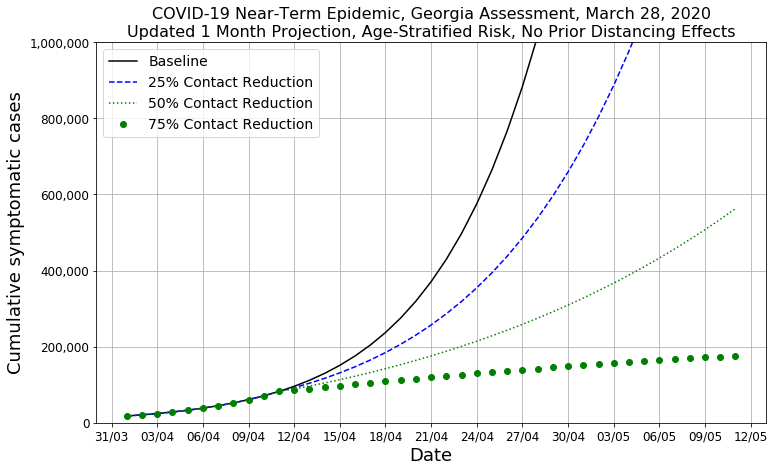

In [108]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(111)

ax.plot(dates, sc_base, 'k', label = "Baseline")
ax.plot(dates, sc_low, 'b--', label = "25% Contact Reduction")
ax.plot(dates, sc_med, 'g:', label = "50% Contact Reduction")
ax.plot(dates, sc_high, 'go', label = "75% Contact Reduction")
ax.set(xlabel = 'Date', ylabel = 'Cumulative symptomatic cases', ylim = (0, 10e5))
ax.xaxis.set_major_formatter(date_form)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.xaxis.set_major_locator(plt.MaxNLocator(15))

plt.rc('axes', titlesize = 16)
plt.rc('xtick', labelsize = 12)   
plt.rc('ytick', labelsize = 12)

plt.grid(which = "major")
plt.legend()
plt.title("""COVID-19 Near-Term Epidemic, Georgia Assessment, March 28, 2020
Updated 1 Month Projection, Age-Stratified Risk, No Prior Distancing Effects""")
plt.show()